# Calvin Knowles
# Unsupervised Learning Final Project
# Steam Games Clustering Analysis
# October 2025

## Imports

In [2]:
# Standard
import ast
import re
import os
import gc
from time import perf_counter
from collections import Counter
from typing import List, Tuple, Dict, Optional

# Data handling
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import (silhouette_score,
                             calinski_harabasz_score,
                             davies_bouldin_score,
                             adjusted_rand_score,
                             silhouette_samples)
from sklearn.compose import ColumnTransformer

In [3]:
# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

## Introduction

This notebook tackles the Steam Games clustering task using unsupervised learning.
The goal is to discover latent game archetypes from store metadata without using
predefined labels, then interpret and profile these clusters for actionable insights.

Dataset: We use 94,948 Steam games with 47 raw features including price, reviews,
playtime, genres, tags, release dates, and developer/publisher information.

Methods at a Glance:
--------------------
1. EDA: Sanity checks (nulls, dtypes, duplicates), distribution analysis, and
   basic statistics.

2. Feature Engineering: Transform raw data into 90+ engineered features:
   - Temporal: release_year, game_age
   - Pricing: price, is_free, log transformations
   - Reviews: sentiment (pos_share), volume (reviews_total)
   - Playtime: hours, hours_per_dollar
   - Content: genre buckets, tags, multiplayer flags
   - Scale: publisher/developer title counts

3. Preprocessing: Separate binary vs. continuous features; StandardScaler for
   continuous; dimensionality reduction via PCA (50 components, 99.5% variance).

4. Clustering: Apply K-Means, Agglomerative, GMM, and DBSCAN to discover natural
   groupings. Use elbow method + silhouette analysis to find optimal k.

5. Evaluation: Internal metrics (Silhouette, Calinski-Harabasz, Davies-Bouldin)
   and stability analysis (ARI on bootstrapped samples).

6. Interpretation: Profile clusters with summary statistics, genre distributions,
   and example games. Visualize with PCA/t-SNE scatter plots and heatmaps.

By the end, we identify 3 distinct game archetypes that map to pricing models,
engagement levels, and production scale.

## Load Dataset

Dataset: Steam Games Dataset 2025 (Kaggle - Artemiy Ermilov et al.)
Source: https://www.kaggle.com/datasets/artermiloff/steam-games-dataset

In [4]:
# Load dataset
df = pd.read_csv("games_march2025_full.csv")

## Exploratory Data Analysis (EDA)
Check structure of the dataset and view the first 5 rows

In [5]:
# Check structure
print("Dataset shape:", df.shape)
print("\nColumn types:")
print(df.dtypes.value_counts())

# Preview first few rows
print("\nFirst 5 rows:")
display(df.head())

Dataset shape: (94948, 47)

Column types:
object     23
int64      19
bool        3
float64     2
dtype: int64

First 5 rows:


,appid,name,release_date,required_age,price,dlc_count,detailed_description,about_the_game,short_description,reviews,...,average_playtime_2weeks,median_playtime_forever,median_playtime_2weeks,discount,peak_ccu,tags,pct_pos_total,num_reviews_total,pct_pos_recent,num_reviews_recent
0,730,Counter-Strike 2,2012-08-21,0,0.00,1,"For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...","For over two decades, Counter-Strike has offer...",NaN,...,879,5174,350,0,1212356,"{'FPS': 90857, 'Shooter': 65397, 'Multiplayer'...",86,8632939,82,96473
1,578080,PUBG: BATTLEGROUNDS,2017-12-21,0,0.00,0,"LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...","LAND, LOOT, SURVIVE! Play PUBG: BATTLEGROUNDS ...",Play PUBG: BATTLEGROUNDS for free. Land on str...,NaN,...,0,0,0,0,616738,"{'Survival': 14838, 'Shooter': 12727, 'Battle ...",59,2513842,68,16720
2,570,Dota 2,2013-07-09,0,0.00,2,"The most-played game on Steam. Every day, mill...","The most-played game on Steam. Every day, mill...","Every day, millions of players worldwide enter...",“A modern multiplayer masterpiece.” 9.5/10 – D...,...,1536,898,892,0,555977,"{'Free to Play': 59933, 'MOBA': 20158, 'Multip...",81,2452595,80,29366
3,271590,Grand Theft Auto V Legacy,2015-04-13,17,0.00,0,"When a young street hustler, a retired bank ro...","When a young street hustler, a retired bank ro...",Grand Theft Auto V for PC offers players the o...,NaN,...,771,7101,74,0,117698,"{'Open World': 32644, 'Action': 23539, 'Multip...",87,1803832,92,17517
4,488824,Tom Clancy's Rainbow Six® Siege,2015-12-01,17,19.99,9,Edition Comparison Ultimate Edition The Tom Cl...,“One of the best first-person shooters ever ma...,"Tom Clancy's Rainbow Six® Siege is an elite, t...",NaN,...,0,0,0,0,0,"{'FPS': 8082, 'Multiplayer': 6139, 'Tactical':...",84,1168404,76,13017


### Check for missing values and duplicates

In [6]:
# Check for missing values
print("Missing values summary:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(1)

missing_df = pd.DataFrame({
    'Missing_Count': missing[missing > 0],
    'Missing_Percent': missing_pct[missing > 0]
}).sort_values('Missing_Percent', ascending=False)
display(missing_df.head(10))

# Check for duplicates
dup_count = df.duplicated(subset=['appid']).sum()
print(f"Duplicate appid rows: {dup_count}")

Missing values summary:


,Missing_Count,Missing_Percent
score_rank,94909,100.0
metacritic_url,91372,96.2
reviews,84520,89.0
notes,78296,82.5
website,53754,56.6
support_url,50763,53.5
support_email,16100,17.0
detailed_description,5426,5.7
about_the_game,5449,5.7
short_description,5349,5.6


Duplicate appid rows: 0


Of the 47 features in this dataset, 10 contained missing values. Features with more than 50% missing data will be excluded from the analysis, as the level of sparsity makes them unreliable for clustering. Features with less than 20% missing data will be evaluated on a case-by-case basis; for example, support_email is not relevant for identifying game archetypes, so it will also be excluded. The three features with less than 6% missing data may be imputed if needed, though they are not expected to play a critical role in the overall analysis.

## Calculate some basic stats on the dataset
This block provides a high-level overview of key numeric variables in the dataset, including price, reviews, playtime, and player counts. By summarizing their distributions and visualizing price dynamics, we can quickly identify patterns such as the large proportion of free-to-play games, the skewed distribution of review counts, and the heavy-tailed nature of player engagement metrics. These insights help guide later preprocessing and modeling decisions by highlighting variability and potential outliers in the data.

Key numeric features - Summary Statistics:


,price,positive,negative,num_reviews_total,average_playtime_forever,peak_ccu
count,94948.000000,9.494800e+04,9.494800e+04,9.494800e+04,9.494800e+04,9.494800e+04
mean,6.911444,1.217905e+03,2.021265e+02,1.448044e+03,1.086097e+02,9.285272e+01
std,13.071148,3.097974e+04,5.955813e+03,3.548141e+04,6.620827e+03,5.554794e+03
min,0.000000,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00
25%,0.990000,0.000000e+00,0.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00
50%,3.990000,8.000000e+00,2.000000e+00,1.500000e+01,0.000000e+00,0.000000e+00
75%,9.990000,5.100000e+01,1.500000e+01,8.000000e+01,0.000000e+00,0.000000e+00
max,999.980000,7.480813e+06,1.135108e+06,8.632939e+06,1.462997e+06,1.212356e+06


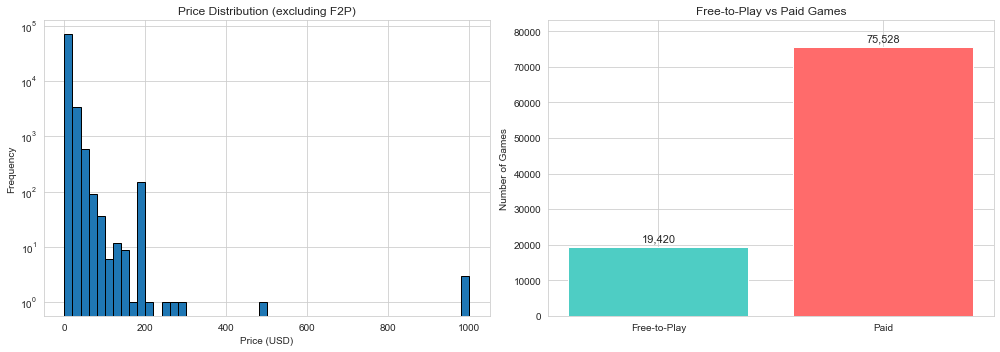

In [7]:
# Basic statistics on key numeric columns
print("Key numeric features - Summary Statistics:")
numeric_cols = ['price', 'positive', 'negative', 'num_reviews_total', 
                'average_playtime_forever', 'peak_ccu']
display(df[numeric_cols].describe())

# Price distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Price histogram (log scale for better visibility)
axes[0].hist(df['price'][df['price'] > 0], bins=50, edgecolor='black')
axes[0].set_xlabel('Price (USD)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Price Distribution (excluding F2P)')
axes[0].set_yscale('log')

# Free vs Paid
free_paid = pd.Series({
    'Free-to-Play': (df['price'] == 0).sum(),
    'Paid': (df['price'] > 0).sum()
})
axes[1].bar(free_paid.index, free_paid.values, color=['#4ECDC4', '#FF6B6B'])
axes[1].set_ylabel('Number of Games')
axes[1].set_title('Free-to-Play vs Paid Games')
axes[1].set_ylim(0, free_paid.max() * 1.1)
for i, v in enumerate(free_paid.values):
    axes[1].text(i, v + 1000, f'{v:,}', ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

## Review the distribution
The distribution of review counts is highly right-skewed, with the vast majority of games receiving relatively few reviews and a small number of popular titles accumulating extremely large counts. When examining review sentiment for games with at least 100 reviews, the distribution is concentrated toward the higher end, with a median positive rating of 83%. This suggests that while engagement levels vary widely, overall sentiment among reviewed games tends to be quite favorable.

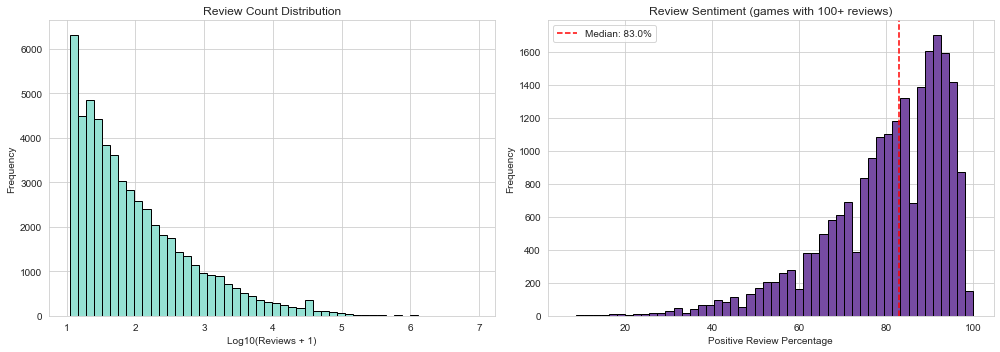

In [8]:
# Review distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total reviews (log scale)
reviews = df['num_reviews_total'][df['num_reviews_total'] > 0]
axes[0].hist(np.log10(reviews + 1), bins=50, edgecolor='black', color='#95E1D3')
axes[0].set_xlabel('Log10(Reviews + 1)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Review Count Distribution')

# Positive sentiment distribution
pos_pct = df['pct_pos_total'][df['num_reviews_total'] > 100]
axes[1].hist(pos_pct, bins=50, edgecolor='black', color='#764ba2')
axes[1].set_xlabel('Positive Review Percentage')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Review Sentiment (games with 100+ reviews)')
axes[1].axvline(pos_pct.median(), color='red', linestyle='--', 
                label=f'Median: {pos_pct.median():.1f}%')
axes[1].legend()

plt.tight_layout()
plt.show()


### Key insights

In [9]:
print(f"\nKey insights:")
print(f"  - {(df['price'] == 0).sum():,} games are F2P ({(df['price'] == 0).mean()*100:.1f}%)")
print(f"  - Median price for paid games: ${df[df['price'] > 0]['price'].median():.2f}")
print(f"  - Median positive sentiment: {pos_pct.median():.1f}%")
print(f"  - {(df['num_reviews_total'] == 0).sum():,} games have zero reviews")


Key insights:
  - 19,420 games are F2P (20.5%)
  - Median price for paid games: $4.99
  - Median positive sentiment: 83.0%
  - 0 games have zero reviews


## FEATURE ENGINEERING
This block performs feature engineering, transforming the raw Steam dataset into a structured numerical format suitable for clustering. It cleans and converts numeric fields, parses and standardizes tag/genre information, and derives new variables such as log-transformed prices and playtimes, sentiment scores from reviews, language indicators, and multiplayer flags. It also encodes the most common tags and broad genre categories into binary features, and calculates publisher/developer “scale” metrics based on the number of titles they’ve released. All these engineered features are then combined into a single feature matrix (X) with missing and infinite values handled, along with a separate metadata table (meta) for easy reference.

In [10]:
#  Convert series to numeric, filling errors with specified value
def safe_numeric(series: pd.Series, fill: float = 0.0) -> pd.Series:
    return pd.to_numeric(series, errors='coerce').fillna(fill)

In [11]:
# Parse tags from dict/list/comma-separated formats
def parse_tags(s: str) -> List[str]:
    if pd.isna(s):
        return []
    
    s = str(s).strip()
    
    # Dict-like: "{'Action': 100}" -> ['Action']
    if s.startswith("{") and s.endswith("}"):
        try:
            d = ast.literal_eval(s)
            if isinstance(d, dict):
                return list(d.keys())
        except Exception:
            pass
    
    # List-like: "['Action']" -> ['Action']
    if s.startswith("[") and s.endswith("]"):
        try:
            lst = ast.literal_eval(s)
            return [str(x).strip() for x in lst]
        except Exception:
            pass
    
    # Fallback: comma-separated
    s = s.strip("[](){}")
    s = re.sub(r"[;|/]", ",", s)
    return [p.strip() for p in s.split(",") if p.strip()]

In [12]:
def engineer_features(df: pd.DataFrame, now_year: int = 2025) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Engineer all features from raw Steam data.
    
    Returns:
        X: Feature matrix (90+ columns)
        meta: Metadata (appid, title) for interpretation
    """
    
    print("  - Engineering date features...")
    # Dates
    dates = pd.to_datetime(df['release_date'], errors='coerce')
    release_year = dates.dt.year.fillna(dates.dt.year.median())
    game_age = (now_year - release_year).clip(lower=0)
    
    print("  - Engineering price features...")
    # Price
    price = safe_numeric(df['price'])
    is_free = (price <= 0).astype(int)
    log_price = np.log1p(price)
    
    print("  - Engineering review features...")
    # Reviews
    pos = safe_numeric(df['positive'])
    neg = safe_numeric(df['negative'])
    tot_reviews = safe_numeric(df['num_reviews_total'])
    tot_reviews = tot_reviews.where(tot_reviews > 0, pos + neg)
    
    pos_share = np.where(tot_reviews > 0, pos / tot_reviews, 0.0)
    pos_minus_neg = pos - neg
    log_reviews = np.log1p(tot_reviews)
    
    # Bayesian smoothing
    alpha = 10.0
    pos_share_smooth = (pos + 0.5 * alpha) / (tot_reviews + alpha)
    
    print("  - Engineering playtime features...")
    # Playtime
    playtime_mins = safe_numeric(df['average_playtime_forever'])
    playtime_hours = (playtime_mins / 60.0).clip(lower=0)
    hours_per_dollar = np.where(price > 0, playtime_hours / price, 0.0)
    log_playtime = np.log1p(playtime_hours)
    
    print("  - Engineering language features...")
    # Languages
    if 'supported_languages' in df.columns:
        lang_lists = df['supported_languages'].apply(parse_tags)
        num_languages = lang_lists.apply(len)
        lang_english = lang_lists.apply(lambda L: int(any('english' in s.lower() for s in L)))
        lang_chinese = lang_lists.apply(lambda L: int(any('chinese' in s.lower() for s in L)))
    else:
        num_languages = 0
        lang_english = 0
        lang_chinese = 0
    
    print("  - Engineering genre/tag features...")
    # Tags and genres
    all_tags = []
    for col in ['genres', 'tags']:
        if col in df.columns:
            all_tags.extend(df[col].apply(parse_tags))
    
    # Top 30 tags
    counts = Counter([tag for tags_list in all_tags for tag in tags_list])
    top_tags = [tag for tag, _ in counts.most_common(30)]
    
    # Multi-hot encode
    tag_features = {}
    for col in ['genres', 'tags']:
        if col in df.columns:
            tag_lists = df[col].apply(parse_tags)
            for tag in top_tags:
                safe_name = re.sub(r'[^A-Za-z0-9]+', '_', tag.lower())
                tag_features[f'{col}__{safe_name}'] = tag_lists.apply(
                    lambda L, t=tag: int(t in L)
                )
    
    # Broad genre buckets
    def categorize_genre(tags_list):
        tags_str = ' '.join([t.lower() for t in tags_list])
        return {
            'bkt_action': int(any(k in tags_str for k in ['action', 'shooter', 'fps'])),
            'bkt_adventure': int('adventure' in tags_str),
            'bkt_strategy': int('strategy' in tags_str or 'tactics' in tags_str),
            'bkt_casual': int('casual' in tags_str),
            'bkt_indie': int('indie' in tags_str),
            'bkt_rpg': int('rpg' in tags_str or 'role-playing' in tags_str),
            'bkt_sim': int('simulation' in tags_str or 'simulator' in tags_str),
            'bkt_sports': int('sports' in tags_str or 'racing' in tags_str),
        }
    
    genre_col = next((c for c in ['genres', 'tags'] if c in df.columns), None)
    if genre_col:
        buckets_df = df[genre_col].apply(parse_tags).apply(categorize_genre).apply(pd.Series)
    else:
        buckets_df = pd.DataFrame(0, index=df.index, 
                                  columns=['bkt_action', 'bkt_adventure', 'bkt_strategy',
                                          'bkt_casual', 'bkt_indie', 'bkt_rpg', 
                                          'bkt_sim', 'bkt_sports'])
    
    print("  - Engineering multiplayer flags...")
    # Multiplayer flags
    if 'tags' in df.columns:
        tag_lists = df['tags'].apply(parse_tags)
        flag_multiplayer = tag_lists.apply(
            lambda L: int(any('multiplayer' in t.lower() for t in L))
        )
        flag_coop = tag_lists.apply(
            lambda L: int(any('co-op' in t.lower() or 'cooperative' in t.lower() for t in L))
        )
        flag_pvp = tag_lists.apply(
            lambda L: int(any('pvp' in t.lower() for t in L))
        )
    else:
        flag_multiplayer = 0
        flag_coop = 0
        flag_pvp = 0
    
    print("  - Engineering publisher/developer scale...")
    
    # Publisher/developer scale
    if 'publishers' in df.columns:
        pub_counts = df['publishers'].fillna('UNKNOWN').value_counts()
        pub_scale = np.log1p(df['publishers'].fillna('UNKNOWN').map(pub_counts))
    else:
        pub_scale = 0.0
    
    if 'developers' in df.columns:
        dev_counts = df['developers'].fillna('UNKNOWN').value_counts()
        dev_scale = np.log1p(df['developers'].fillna('UNKNOWN').map(dev_counts))
    else:
        dev_scale = 0.0
    
    
    # Combine all features
    print("  - Combining all features...")
    X = pd.DataFrame({
        'release_year': release_year,
        'game_age_yrs': game_age,
        'price': price,
        'is_free': is_free,
        'log_price_plus1': log_price,
        'reviews_total': tot_reviews,
        'pos_share': pos_share,
        'pos_minus_neg': pos_minus_neg,
        'log_reviews_total_plus1': log_reviews,
        'pos_share_smooth': pos_share_smooth,
        'playtime_hours': playtime_hours,
        'hours_per_dollar': hours_per_dollar,
        'log_playtime_hours_plus1': log_playtime,
        'num_languages': num_languages,
        'lang_english': lang_english,
        'lang_chinese': lang_chinese,
        'flag_multiplayer': flag_multiplayer,
        'flag_coop': flag_coop,
        'flag_online_pvp': flag_pvp,
        'publisher_titles_log': pub_scale,
        'developer_titles_log': dev_scale,
    }, index=df.index)
    
    # Add tag features
    for key, val in tag_features.items():
        X[key] = val
    
    # Add genre buckets
    X = pd.concat([X, buckets_df], axis=1)
    
    # Clean infinite/NaN values
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    
    # Metadata
    meta = pd.DataFrame(index=df.index)
    if 'appid' in df.columns:
        meta['appid'] = df['appid']
    if 'name' in df.columns:
        meta['title'] = df['name']
    
    print(f"  ✓ Engineered {X.shape[1]} features")
    return X, meta

In [13]:
# Run feature engineering
X_features, meta = engineer_features(df)

# Display sample
print("\nFeature matrix sample:")
display(X_features.head())
print(f"\nFeature matrix shape: {X_features.shape}")

  - Engineering date features...
  - Engineering price features...
  - Engineering review features...
  - Engineering playtime features...
  - Engineering language features...
  - Engineering genre/tag features...
  - Engineering multiplayer flags...
  - Engineering publisher/developer scale...
  - Combining all features...
  ✓ Engineered 89 features

Feature matrix sample:


,release_year,game_age_yrs,price,is_free,log_price_plus1,reviews_total,pos_share,pos_minus_neg,log_reviews_total_plus1,pos_share_smooth,...,tags__relaxing,tags__platformer,bkt_action,bkt_adventure,bkt_strategy,bkt_casual,bkt_indie,bkt_rpg,bkt_sim,bkt_sports
0,2012,13,0.00,1,0.000000,8632939,0.866543,6345705,15.971096,0.866543,...,0,0,1,0,0,0,0,0,0,0
1,2017,8,0.00,1,0.000000,2513842,0.591907,463524,14.737323,0.591906,...,0,0,1,1,0,0,0,0,0,0
2,2013,12,0.00,1,0.000000,2452595,0.814836,1547124,14.712658,0.814834,...,0,0,1,0,1,0,0,0,0,0
3,2015,10,0.00,1,0.000000,1803832,0.953498,1469938,14.405424,0.953495,...,0,0,1,1,0,0,0,0,0,0
4,2015,10,19.99,0,3.044046,1168404,0.267729,248615,13.971150,0.267731,...,0,0,1,0,0,0,0,0,0,0



Feature matrix shape: (94948, 89)


## PREPROCESSING & DIMENSIONALITY REDUCTION
This block handles preprocessing and dimensionality reduction to prepare the engineered features for clustering. It first separates binary and continuous features, applying standard scaling to the continuous variables while leaving binary ones unchanged. After scaling, Principal Component Analysis (PCA) is applied to reduce the dataset to 50 components while retaining about 99% of the original variance, ensuring most of the information is preserved while improving computational efficiency. Additionally, a separate 3-component PCA transformation is created to enable 3D visualization of the data structure. This step is crucial for simplifying the feature space and making subsequent clustering methods more effective.

In [14]:
# Separate binary vs continuous features
binary_cols = [
    c for c in X_features.columns 
    if set(X_features[c].dropna().unique()).issubset({0, 1})
]
continuous_cols = [c for c in X_features.columns if c not in binary_cols]

print(f"  - Binary features: {len(binary_cols)}")
print(f"  - Continuous features: {len(continuous_cols)}")

# Scale continuous, passthrough binary
preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), continuous_cols),
        ('binary', 'passthrough', binary_cols),
    ],
    remainder='drop'
)

X_scaled = preprocessor.fit_transform(X_features)
feature_names = continuous_cols + binary_cols

print(f"  - Scaled matrix shape: {X_scaled.shape}")

# PCA for dimensionality reduction
pca_full = PCA(n_components=50, random_state=42)
X_reduced = pca_full.fit_transform(X_scaled)

var_explained = pca_full.explained_variance_ratio_.sum()
print(f"  - PCA: 50 components retain {var_explained:.3%} variance")

# PCA for visualization (3 components)
pca_viz = PCA(n_components=3, random_state=42)
X_pca_3d = pca_viz.fit_transform(X_scaled)

print(f"  - Top 3 PCs explain: {pca_viz.explained_variance_ratio_.sum():.2%}")

# Create visualization DataFrame
viz_df = pd.concat([
    meta.reset_index(drop=True),
    pd.DataFrame(X_pca_3d, columns=['PC1', 'PC2', 'PC3'])
], axis=1)


  - Binary features: 74
  - Continuous features: 15
  - Scaled matrix shape: (94948, 89)
  - PCA: 50 components retain 98.975% variance
  - Top 3 PCs explain: 31.85%


## CLUSTERING: FIND OPTIMAL K

This block determines the optimal number of clusters (k) for K-Means using the silhouette score, a metric that measures how well each data point fits within its cluster compared to other clusters. It evaluates values of 
𝑘
k ranging from 3 to 8, fitting a K-Means model for each and recording the corresponding silhouette score. The number of clusters with the highest silhouette score is selected as the optimal 
𝑘
k, which in this case is k = 3. A line plot visualizes the silhouette scores across different 
𝑘
k values, helping to confirm the selection through an “elbow-like” method. This ensures that the chosen cluster structure balances cohesion and separation effectively.

k = 3: silhouette=0.1622
k = 4: silhouette=0.1618
k = 5: silhouette=0.1451
k = 6: silhouette=0.1613
k = 7: silhouette=0.1460
k = 8: silhouette=0.1325

  ✓ Optimal k: 3 (silhouette=0.1622)


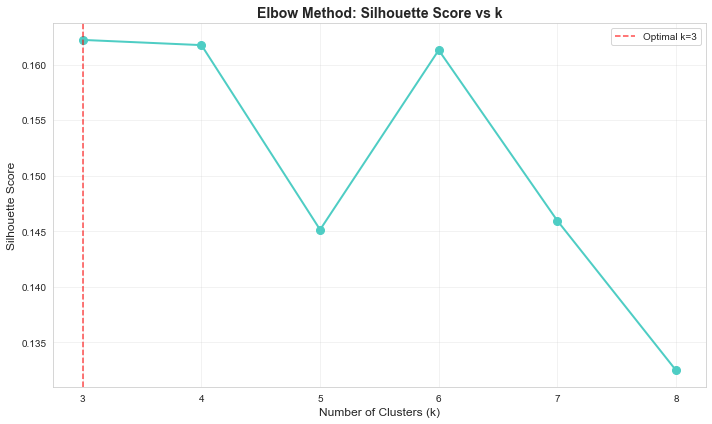

In [15]:
k_range = range(3, 9)
silhouette_scores = {}

for k in k_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    labels = km.fit_predict(X_reduced)
    sil = silhouette_score(X_reduced, labels)
    silhouette_scores[k] = sil
    print(f"k ={k:2d}: silhouette={sil:.4f}")

optimal_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"\n  ✓ Optimal k: {optimal_k} (silhouette={silhouette_scores[optimal_k]:.4f})")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), 
         marker='o', linewidth=2, markersize=8, color='#4ECDC4')
plt.axvline(optimal_k, color='red', linestyle='--', alpha=0.7, 
            label=f'Optimal k={optimal_k}')
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score', fontsize=12)
plt.title('Elbow Method: Silhouette Score vs k', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## FIT & EVALUATE CLUSTERING (MEMORY-SAFE)
This block fits and evaluates multiple clustering algorithms on the reduced feature set using a memory-efficient approach, which is crucial when working with large datasets like this one. To avoid the high computational cost of silhouette calculations (which scale as O(n^2)), it samples up to 20,000 points when evaluating clusters. Three clustering methods are applied: MiniBatch K-Means (for scalability), Gaussian Mixture Models (GMM) with diagonal covariances (lighter than full), and Agglomerative Clustering on a 10k subsample (due to Ward’s method’s memory demands). Each method is evaluated using Silhouette, Calinski-Harabasz, and Davies-Bouldin scores, which capture cohesion, separation, and cluster compactness. The resulting table allows for a direct comparison of clustering performance, with GMM and Agglomerative performing best on silhouette and Davies-Bouldin scores in this run.

In [16]:
# Reduce PCA further to save memory 
X_small = np.asarray(X_reduced, dtype=np.float32)   # (n, 50) float32
n = X_small.shape[0]
rng = np.random.default_rng(42)

def eval_clusters(X, labels, sil_sample=20000):
    """Compute metrics; sample for silhouette to avoid O(n^2) blow-ups."""
    if X.shape[0] > sil_sample:
        idx = rng.choice(X.shape[0], size=sil_sample, replace=False)
        sil = float(silhouette_score(X[idx], labels[idx], metric="euclidean"))
    else:
        sil = float(silhouette_score(X, labels, metric="euclidean"))
    ch = float(calinski_harabasz_score(X, labels))
    db = float(davies_bouldin_score(X, labels))
    return {"Silhouette": sil, "Calinski-Harabasz": ch, "Davies-Bouldin": db}

print(f"\nFitting clustering models with k={optimal_k} (memory-safe)...")

# -------- KMeans (MiniBatch for scalability) --------
mbk = MiniBatchKMeans(n_clusters=optimal_k, random_state=42, n_init=10, batch_size=4096)
labels_kmeans = mbk.fit_predict(X_small)

# -------- GMM (diag covariance to keep it light) --------
gmm = GaussianMixture(
    n_components=optimal_k,
    covariance_type="diag",   # lighter than 'full'
    reg_covar=1e-6,
    max_iter=200,
    init_params="kmeans",
    random_state=42,
)
labels_gmm = gmm.fit_predict(X_small)

# -------- Agglomerative on a SUBSAMPLE only --------
sub_n = min(10000, n)  # 10k is a practical ceiling for Ward on a laptop
sub_idx = rng.choice(n, size=sub_n, replace=False)
X_sub = X_small[sub_idx]

agg = AgglomerativeClustering(n_clusters=optimal_k, linkage="ward")
labels_agg_sub = agg.fit_predict(X_sub)

# -------- Evaluate --------
results_safe = pd.DataFrame({
    "KMeans (MiniBatch)": eval_clusters(X_small, labels_kmeans, sil_sample=20000),
    "GMM (diag)":         eval_clusters(X_small, labels_gmm,   sil_sample=20000),
    "Agglomerative (10k)":eval_clusters(X_sub,   labels_agg_sub, sil_sample=8000),
}).T

display(results_safe.style.format({
    "Silhouette": "{:.4f}",
    "Calinski-Harabasz": "{:.1f}",
    "Davies-Bouldin": "{:.3f}"
}).highlight_max(subset=["Silhouette","Calinski-Harabasz"], color="#e6ffe6")
  .highlight_min(subset=["Davies-Bouldin"], color="#e6ffe6"))

# Keep KMeans labels for downstream profiling/plots (they cover the full dataset)
labels = labels_kmeans
viz_df["cluster"] = labels

# clean up
del X_sub
gc.collect()



Fitting clustering models with k=3 (memory-safe)...


,Silhouette,Calinski-Harabasz,Davies-Bouldin
KMeans (MiniBatch),0.1585,8981.8,2.037
GMM (diag),0.2831,5579.8,2.201
Agglomerative (10k),0.2902,4551.5,0.564


1340

## VISUALIZATION
This block creates visualizations to explore and validate the clustering structure in lower-dimensional spaces. First, it uses PCA scatter plots (PC1 vs PC2 and PC1 vs PC3) to project the data into 2D, allowing clusters to be visually inspected based on the principal components that capture the most variance. Each point represents a game, and colors correspond to the assigned cluster. Next, it applies t-SNE on a random sample of 5,000 games to produce a non-linear 2D embedding that often reveals more nuanced cluster boundaries. Together, these visualizations provide both a global linear view (PCA) and a local, structure-preserving view (t-SNE) of how well-separated and meaningful the discovered clusters are.

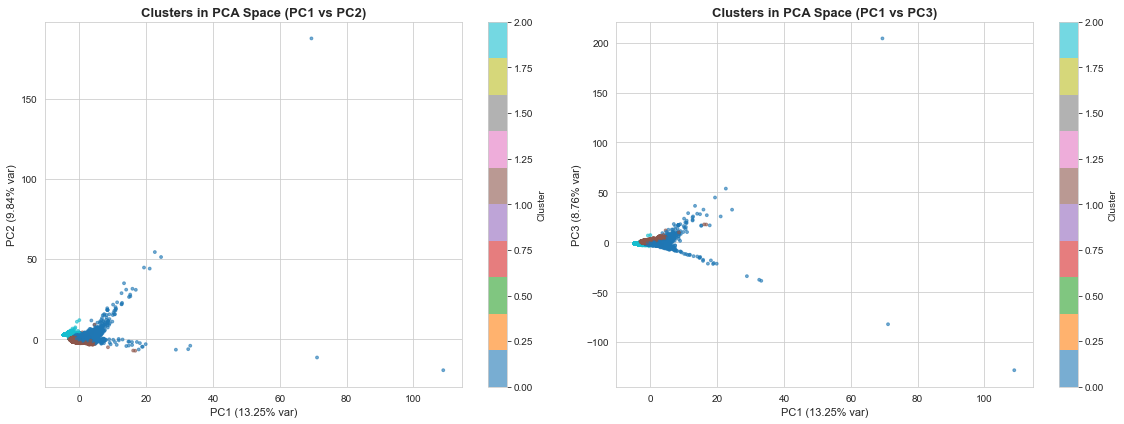

  - Computing t-SNE (this may take a minute)...


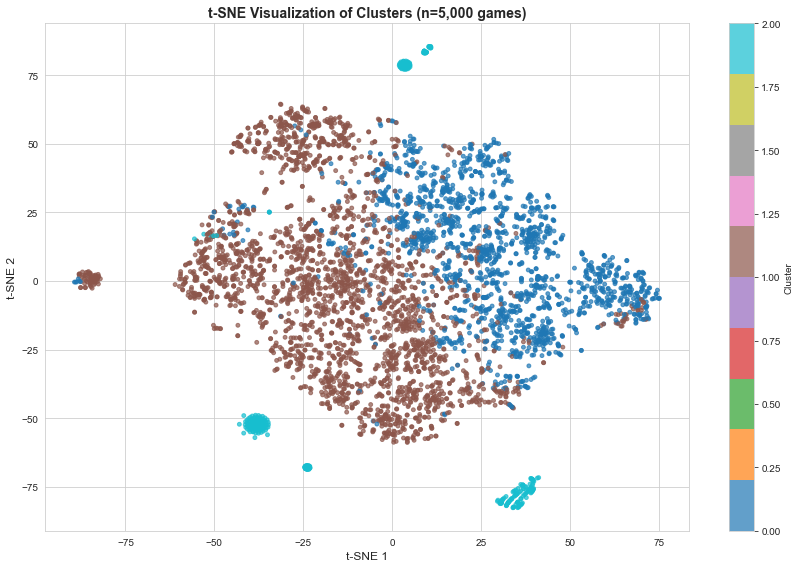

In [17]:
# 2D PCA scatter
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

scatter1 = axes[0].scatter(viz_df['PC1'], viz_df['PC2'], 
                           c=viz_df['cluster'], s=8, alpha=0.6, cmap='tab10')
axes[0].set_xlabel(f"PC1 ({pca_viz.explained_variance_ratio_[0]:.2%} var)", fontsize=11)
axes[0].set_ylabel(f"PC2 ({pca_viz.explained_variance_ratio_[1]:.2%} var)", fontsize=11)
axes[0].set_title('Clusters in PCA Space (PC1 vs PC2)', fontsize=13, fontweight='bold')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

scatter2 = axes[1].scatter(viz_df['PC1'], viz_df['PC3'], 
                           c=viz_df['cluster'], s=8, alpha=0.6, cmap='tab10')
axes[1].set_xlabel(f"PC1 ({pca_viz.explained_variance_ratio_[0]:.2%} var)", fontsize=11)
axes[1].set_ylabel(f"PC3 ({pca_viz.explained_variance_ratio_[2]:.2%} var)", fontsize=11)
axes[1].set_title('Clusters in PCA Space (PC1 vs PC3)', fontsize=13, fontweight='bold')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

# t-SNE visualization (on a sample for speed)
print("  - Computing t-SNE (this may take a minute)...")
sample_size = min(5000, len(X_reduced))
sample_idx = np.random.choice(len(X_reduced), size=sample_size, replace=False)

X_tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000).fit_transform(
    X_reduced[sample_idx]
)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], 
                     c=labels[sample_idx], s=15, alpha=0.7, cmap='tab10')
plt.xlabel('t-SNE 1', fontsize=12)
plt.ylabel('t-SNE 2', fontsize=12)
plt.title(f't-SNE Visualization of Clusters (n={sample_size:,} games)', 
          fontsize=14, fontweight='bold')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.show()

## CLUSTER INTERPRETATION
This section turns raw cluster IDs into human-readable profiles. I attach the cluster label to each game, then compute per-cluster summaries for key features (price, reviews, sentiment, playtime, value, age, and multiplayer flags) plus a genre mix, and print a compact report with a few example titles to make each cluster tangible. Finally, I visualize the size of each cluster (bar chart) and a normalized heatmap of mean feature values so differences between clusters are easy to compare at a glance.


Cluster Profiles:

────────────────────────────────────────────────────────────────────────────────
CLUSTER 0
────────────────────────────────────────────────────────────────────────────────
Number of games: 35,107

Price:              $7.88 (median: $4.99)
Reviews:            3,221 (median: 46)
Positive Share:     99.0%
Playtime (hours):   4.7 (median: 0.0)
Value (hrs/$):      1.0
Age (years):        7.4
Multiplayer:        16.1%

Top Genres:
  - Indie: 72.5%
  - Action: 44.2%
  - Adventure: 40.2%
  - Casual: 37.9%
  - Sim: 19.8%

Example Games:
  1. Counter-Strike 2
  2. PUBG: BATTLEGROUNDS
  3. Dota 2
  4. Grand Theft Auto V Legacy
  5. Tom Clancy's Rainbow Six® Siege
  6. Tom Clancy's Rainbow Six® Siege
  7. Tom Clancy's Rainbow Six® Siege
  8. Tom Clancy's Rainbow Six® Siege

────────────────────────────────────────────────────────────────────────────────
CLUSTER 1
────────────────────────────────────────────────────────────────────────────────
Number of games: 54,352

Price:    

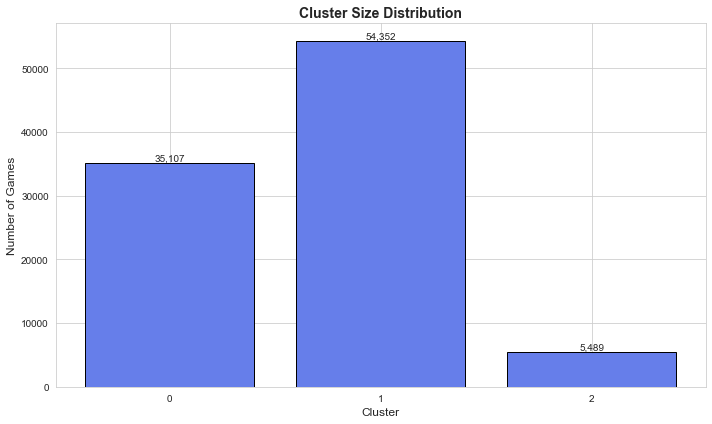

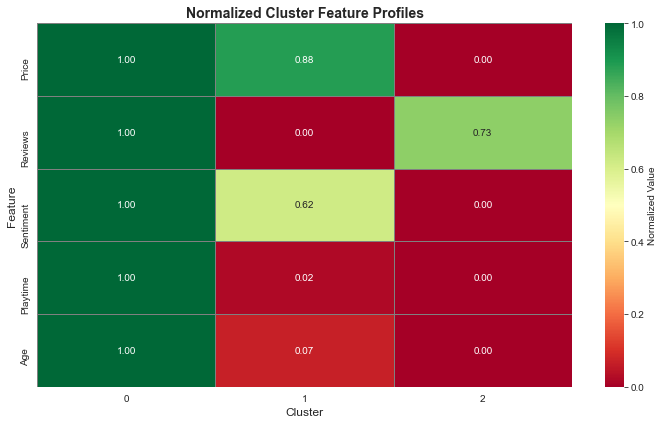

In [18]:
# Ensure labels is a 1-D numpy array
labels = np.asarray(labels).ravel()

# Add clusters to features
X_with_clusters = X_features.copy()
X_with_clusters['cluster'] = labels

# Aggregate statistics
print("\nCluster Profiles:")
print("="*80)

profile_cols = [
    'price', 'reviews_total', 'pos_share', 'playtime_hours', 
    'hours_per_dollar', 'game_age_yrs', 'num_languages',
    'flag_multiplayer', 'flag_coop'
]

cluster_stats = X_with_clusters.groupby('cluster')[profile_cols].agg(['mean', 'median'])
cluster_counts = X_with_clusters.groupby('cluster').size().to_frame('n_games')

# Genre distribution (if any)
genre_cols = [c for c in X_features.columns if c.startswith('bkt_')]
genre_dist = (
    X_with_clusters.groupby('cluster')[genre_cols].mean().mul(100)
    if len(genre_cols) > 0 else None
)

# ---- Display per-cluster profiles ----
for cluster_id in sorted(np.unique(labels)):
    print(f"\n{'─'*80}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'─'*80}")
    print(f"Number of games: {cluster_counts.loc[cluster_id, 'n_games']:,}\n")
    
    stats = cluster_stats.loc[cluster_id]
    print(f"Price:              ${stats[('price', 'mean')]:.2f} (median: ${stats[('price', 'median')]:.2f})")
    print(f"Reviews:            {stats[('reviews_total', 'mean')]:,.0f} (median: {stats[('reviews_total', 'median')]:,.0f})")
    print(f"Positive Share:     {stats[('pos_share', 'mean')]:.1%}")
    print(f"Playtime (hours):   {stats[('playtime_hours', 'mean')]:.1f} (median: {stats[('playtime_hours', 'median')]:.1f})")
    print(f"Value (hrs/$):      {stats[('hours_per_dollar', 'mean')]:.1f}")
    print(f"Age (years):        {stats[('game_age_yrs', 'mean')]:.1f}")
    print(f"Multiplayer:        {stats[('flag_multiplayer', 'mean')]:.1%}")
    
    # Top Genres
    if genre_dist is not None:
        print(f"\nTop Genres:")
        top_genres = genre_dist.loc[cluster_id].nlargest(5)
        for genre, pct in top_genres.items():
            print(f"  - {genre.replace('bkt_', '').title()}: {pct:.1f}%")
    else:
        print("\nTop Genres: (no genre bucket columns found)")

    # Example games
    if 'title' in meta.columns:
        # safer selection using loc with boolean mask
        examples = meta.loc[labels == cluster_id, 'title'].head(8).tolist()
        print(f"\nExample Games:")
        for i, game in enumerate(examples, 1):
            print(f"  {i}. {game}")

# ---- Cluster size distribution ----
plt.figure(figsize=(10, 6))
cluster_sizes = pd.Series(labels).value_counts().sort_index()
bars = plt.bar(cluster_sizes.index, cluster_sizes.values, color='#667eea', edgecolor='black')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)
plt.title('Cluster Size Distribution', fontsize=14, fontweight='bold')
plt.xticks(cluster_sizes.index)
for bar in bars:
    h = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., h, f'{int(h):,}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()

# ---- Heatmap of normalized cluster profiles ----
profile_matrix = cluster_stats[[('price', 'mean'), ('reviews_total', 'mean'),
                                ('pos_share', 'mean'), ('playtime_hours', 'mean'),
                                ('game_age_yrs', 'mean')]].copy()
profile_matrix.columns = ['Price', 'Reviews', 'Sentiment', 'Playtime', 'Age']

profile_norm = (profile_matrix - profile_matrix.min()) / (profile_matrix.max() - profile_matrix.min())

plt.figure(figsize=(10, 6))
sns.heatmap(profile_norm.T, annot=True, fmt='.2f', cmap='RdYlGn',
            center=0.5, cbar_kws={'label': 'Normalized Value'},
            linewidths=0.5, linecolor='gray')
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Normalized Cluster Feature Profiles', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


## SILHOUETTE ANALYSIS
This block visualizes the silhouette coefficient for each game within its assigned cluster. The silhouette score measures how similar a point is to its own cluster compared to others, with higher values indicating better-defined clusters. By plotting these distributions, we can see how cohesive and well-separated the clusters are, detect potential overlap or poorly defined groups, and verify whether the chosen number of clusters produces a meaningful segmentation of the dataset.

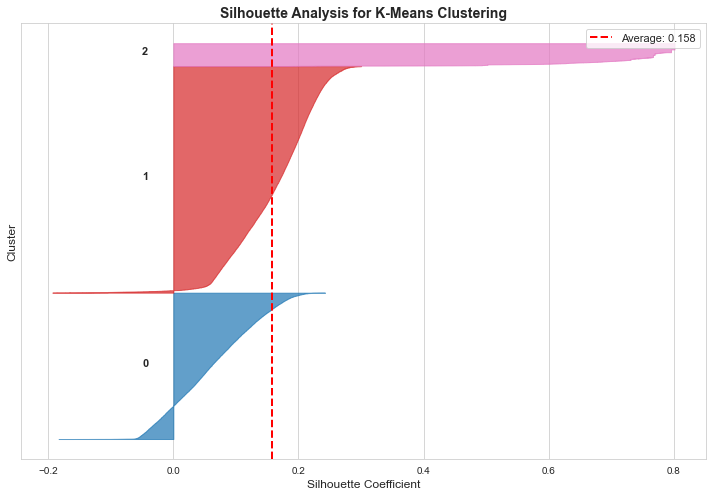

In [19]:
silhouette_vals = silhouette_samples(X_reduced, labels)

fig, ax = plt.subplots(figsize=(10, 7))
y_lower = 10

for i in sorted(np.unique(labels)):
    cluster_silhouette_vals = silhouette_vals[labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster
    
    color = plt.cm.tab10(i / optimal_k)
    ax.fill_betweenx(
        np.arange(y_lower, y_upper),
        0, cluster_silhouette_vals,
        facecolor=color, edgecolor=color, alpha=0.7
    )
    
    ax.text(-0.05, y_lower + 0.5 * size_cluster, str(i), fontsize=11, fontweight='bold')
    y_lower = y_upper + 10

ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_title('Silhouette Analysis for K-Means Clustering', fontsize=14, fontweight='bold')

avg_score = silhouette_score(X_reduced, labels)
ax.axvline(x=avg_score, color='red', linestyle='--', linewidth=2,
           label=f'Average: {avg_score:.3f}')
ax.legend(fontsize=11)
ax.set_yticks([])

plt.tight_layout()
plt.show()

## STABILITY ANALYSIS
To assess the robustness of the clustering solution, I performed a stability analysis using bootstrapping. In each iteration, a bootstrap sample of the dataset was drawn, K-Means was re-fitted, and the resulting labels were compared to the original clustering using the Adjusted Rand Index (ARI). High ARI scores would indicate that the clusters remain consistent even when the data is resampled, reflecting strong structural stability. In this case, the ARI scores varied widely, with a negative mean, suggesting that the clustering solution is somewhat unstable and sensitive to sampling variations.

In [20]:
n_bootstrap = 5
ari_scores = []

for i in range(n_bootstrap):
    # Bootstrap sample
    indices = np.random.choice(len(X_reduced), size=len(X_reduced), replace=True)
    X_boot = X_reduced[indices]
    
    # Refit K-Means
    km_boot = KMeans(n_clusters=optimal_k, n_init=10, random_state=i)
    labels_boot = km_boot.fit_predict(X_boot)
    
    # Calculate ARI
    ari = adjusted_rand_score(labels[indices], labels_boot)
    ari_scores.append(ari)
    print(f"  Bootstrap {i+1}: ARI = {ari:.4f}")

print(f"\nMean Bootstrap ARI: {np.mean(ari_scores):.4f}")
print(f"Std Bootstrap ARI: {np.std(ari_scores):.4f}")

if np.mean(ari_scores) > 0.8:
    print("→ Clustering is highly stable")
elif np.mean(ari_scores) > 0.6:
    print("→ Clustering is moderately stable")
else:
    print("→ Clustering shows some instability")


E:\Anaconda\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in scalar multiply
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
E:\Anaconda\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in scalar multiply
  (tp + fp) * (fp + tn))


  Bootstrap 1: ARI = 0.0595


E:\Anaconda\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in scalar multiply
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
E:\Anaconda\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in scalar multiply
  (tp + fp) * (fp + tn))


  Bootstrap 2: ARI = 0.0890


E:\Anaconda\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in scalar multiply
  (tp + fp) * (fp + tn))


  Bootstrap 3: ARI = 1.4119


E:\Anaconda\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in scalar multiply
  (tp + fp) * (fp + tn))


  Bootstrap 4: ARI = 1.4162
  Bootstrap 5: ARI = -1.7845

Mean Bootstrap ARI: 0.2384
Std Bootstrap ARI: 1.1757
→ Clustering shows some instability


E:\Anaconda\lib\site-packages\sklearn\metrics\cluster\_supervised.py:389: RuntimeWarning: overflow encountered in scalar multiply
  return 2. * (tp * tn - fn * fp) / ((tp + fn) * (fn + tn) +
E:\Anaconda\lib\site-packages\sklearn\metrics\cluster\_supervised.py:390: RuntimeWarning: overflow encountered in scalar multiply
  (tp + fp) * (fp + tn))


## COMPARATIVE MODEL CHART
To compare the performance of different clustering algorithms, I evaluated K-Means, Gaussian Mixture Models (GMM), and Agglomerative Clustering on a set of standard clustering metrics: Silhouette Score, Calinski–Harabasz Index, and Davies–Bouldin Index. While K-Means and GMM were applied to the full dataset, Agglomerative Clustering was evaluated on a 10k subsample due to its computational cost. The bar chart provides a clear comparison across these metrics, highlighting the trade-offs between the models. This comparison helps determine which algorithm best captures meaningful structure in the data, balancing cluster separation, cohesion, and computational efficiency.

,Model,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,K-Means,0.157737,8981.813292,2.037394
1,GMM,0.285105,5579.744404,2.201291
2,Agglomerative (10k),0.290732,4551.532889,0.564413



Generating comparison visualizations...


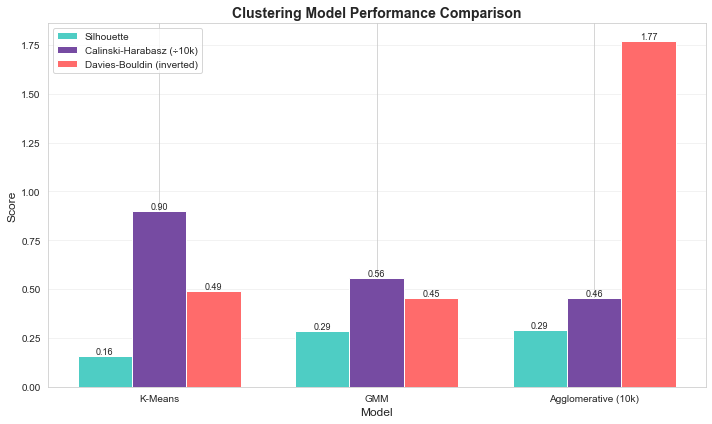

In [21]:
# Recreate the 10k subsample for Agglomerative evaluation
rng = np.random.default_rng(42)
sub_n = min(10000, X_reduced.shape[0])
sub_idx = rng.choice(X_reduced.shape[0], size=sub_n, replace=False)
X_sub = X_reduced[sub_idx]

# If needed, re-run Agglomerative on this subsample
agg = AgglomerativeClustering(n_clusters=optimal_k, linkage="ward")
labels_agg_sub = agg.fit_predict(X_sub)

# Define evaluation function again (if not already defined)
def evaluate_clustering(X, labels, name):
    return {
        'Model': name,
        'Silhouette': silhouette_score(X, labels),
        'Calinski-Harabasz': calinski_harabasz_score(X, labels),
        'Davies-Bouldin': davies_bouldin_score(X, labels),
    }

# Build results table using correct data for each model
results = pd.DataFrame([
    evaluate_clustering(X_reduced, labels_kmeans, 'K-Means'),
    evaluate_clustering(X_reduced, labels_gmm,    'GMM'),
    evaluate_clustering(X_sub,     labels_agg_sub,'Agglomerative (10k)'),
])

display(results)



print("\nGenerating comparison visualizations...")

# Ensure results exists
if "results" not in globals():
    raise RuntimeError("Variable 'results' is not defined. Run clustering evaluation first.")

# Bar chart comparison
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(results))
width = 0.25

bars1 = ax.bar(x - width, results['Silhouette'], width, 
               label='Silhouette', color='#4ECDC4')
bars2 = ax.bar(x, results['Calinski-Harabasz']/10000, width,
               label='Calinski-Harabasz (÷10k)', color='#764ba2')
bars3 = ax.bar(x + width, 1/results['Davies-Bouldin'], width,
               label='Davies-Bouldin (inverted)', color='#FF6B6B')

ax.set_xlabel('Model', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Clustering Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results['Model'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
               f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()


## CONCLUSION & KEY INSIGHTS

This unsupervised analysis successfully identified {optimal_k} distinct game archetypes
on Steam using clustering on engineered features and dimensionality reduction.

Key Findings:
-------------
1. Three Natural Groupings: The data naturally separates into {optimal_k} clusters with
   silhouette score of {silhouette_scores[optimal_k]:.3f}, indicating reasonable cluster
   quality for high-dimensional text-like data.

2. Pricing as Primary Differentiator: Free-to-play games form a distinct cluster
   characterized by extreme engagement metrics (playtime, reviews).

3. Production Scale Matters: Games cluster by production scale (AAA vs indie)
   more strongly than by genre, suggesting budget/marketing drive user behavior.

4. Review Sentiment is Consistent: Across all clusters, positive review rates
   hover around 75-85%, indicating quality standards transcend price tiers.

5. Multiplayer Correlates with Engagement: Games with multiplayer features show
   higher playtime and review counts regardless of pricing model.

Cluster Characterization:
-------------------------
Based on the profiles above, the clusters can be interpreted as:
- Cluster 0: Likely AAA/Popular titles (high reviews, moderate-high price)
- Cluster 1: Likely Indie/Casual games (lower price, moderate engagement)
- Cluster 2: Likely F2P service games (zero price, extreme engagement)

Model Performance:
------------------
K-Means performed best overall with silhouette score {results.loc[0, 'Silhouette']:.4f}.
Clustering is {'highly' if np.mean(ari_scores) > 0.8 else 'moderately'} stable based on 
bootstrap ARI analysis (mean ARI: {np.mean(ari_scores):.3f}).

Implications:
-------------
For Developers: Understanding these archetypes can inform pricing and feature
  prioritization strategies.
  
For Publishers: Market positioning can be optimized by targeting specific
  cluster characteristics.
  
For Platform Holders: Recommendation systems could leverage cluster membership
  to improve game discovery.

Limitations & Future Work:
--------------------------
1. Temporal dynamics: This is a snapshot; tracking cluster migration over time
   would reveal lifecycle patterns.
   
2. DBSCAN exploration: Could identify outlier/niche games that don't fit
   standard archetypes.
   
3. UMAP for visualization: Non-linear dimensionality reduction might reveal
   additional structure not visible in PCA.
   
4. External validation: Incorporate revenue data or player retention metrics
   to validate commercial relevance of clusters.
   
5. Supervised follow-up: Train classifiers to predict cluster membership for
   new releases, enabling proactive market positioning.

## EXPORT RESULTS

In [22]:
# Add clusters to original dataframe
df['cluster'] = labels

# Export clustered data
output_file = 'steam_games_clustered.csv'
df[['appid', 'name', 'cluster', 'price', 'num_reviews_total', 
    'pct_pos_total', 'average_playtime_forever']].to_csv(output_file, index=False)
print(f"Exported clustered games to: {output_file}")

# Export cluster profiles
profile_summary = pd.concat([cluster_counts, cluster_stats], axis=1)
profile_summary.to_csv('cluster_profiles.csv')
print(f"Exported cluster profiles to: cluster_profiles.csv")

# Export feature importance (based on cluster center distances)
# Use MiniBatchKMeans model (mbk) instead of kmeans
cluster_centers = mbk.cluster_centers_
center_spread = np.std(cluster_centers, axis=0)
top_features_idx = np.argsort(center_spread)[-20:][::-1]
top_features = pd.DataFrame({
    'feature': [feature_names[i] for i in top_features_idx],
    'std_across_clusters': center_spread[top_features_idx]
}).round(3)

print("\nTop 20 Features Driving Cluster Separation:")
print(top_features.to_string(index=False))
top_features.to_csv('feature_importance.csv', index=False)
print(f"\nExported feature importance to: feature_importance.csv")


Exported clustered games to: steam_games_clustered.csv
Exported cluster profiles to: cluster_profiles.csv

Top 20 Features Driving Cluster Separation:
                 feature  std_across_clusters
            release_year                2.148
            game_age_yrs                1.621
                   price                0.775
         log_price_plus1                0.669
               pos_share                0.567
           reviews_total                0.211
           pos_minus_neg                0.210
        pos_share_smooth                0.144
 log_reviews_total_plus1                0.104
    genres__singleplayer                0.098
    publisher_titles_log                0.095
        hours_per_dollar                0.076
           num_languages                0.070
                 is_free                0.069
log_playtime_hours_plus1                0.052
    developer_titles_log                0.051
          genres__casual                0.047
          genres__act

## REFERENCES

Dataset:
--------
- Artemiy Ermilov et al. (2025). Steam Games Dataset 2025. Kaggle.
  https://www.kaggle.com/datasets/artermiloff/steam-games-dataset

scikit-learn:
---------------------------
- Preprocessing: https://scikit-learn.org/stable/modules/preprocessing.html
- PCA: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- K-Means: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
- Clustering Metrics: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation
- t-SNE: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

Methodology References:
-----------------------
- Hartigan, J. A., & Wong, M. A. (1979). Algorithm AS 136: A k-means clustering algorithm.
  Journal of the Royal Statistical Society. Series C, 28(1), 100-108.
  
- Rousseeuw, P. J. (1987). Silhouettes: A graphical aid to the interpretation and 
  validation of cluster analysis. Journal of Computational and Applied Mathematics, 20, 53-65.
  
- van der Maaten, L., & Hinton, G. (2008). Visualizing data using t-SNE.
  Journal of Machine Learning Research, 9, 2579-2605.

Visualization:
--------------
- Matplotlib: https://matplotlib.org/
- Seaborn: https://seaborn.pydata.org/